# **Comparing Four Machine Learning Models and an Ensemble for Predicting Heart Attacks from Routine Clinical Features**

***Authors: Oliver Olejar, Micky Huynh, Jinil Desai***

## Variable Breakdown

**Age:** The patient's age  
**Gender:** Biological sex of the patient (The male is set to 1 and the female to 0)  
**Heart Rate:** The number of heartbeats per minute  
**Systolic Blood Pressure:** The pressure in arteries when the heart contracts  
**Diastolic Blood Pressure:** The pressure in arteries between heartbeats  
**Blood Sugar:** The patient's blood glucose level  
**Ck-mb:** A cardiac enzyme released during heart muscle damage  
**Troponin:** A highly specific protein biomarker for heart muscle injury  
**Result:** The outcome label indicating whether or not the patient experienced a heart attack  

## Importing Necessary Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,      
    average_precision_score,
    confusion_matrix,
    roc_curve
)
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils._tags import Tags, InputTags, TargetTags, ClassifierTags

from xgboost import XGBClassifier

from tabpfn import TabPFNClassifier

import torch
from torch import nn
from torch import optim

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load Dataset

In [4]:
df = pd.read_csv('Medicaldataset.csv')

df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [5]:
df.tail()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
1314,44,1,94,122,67,204.0,1.63,0.006,negative
1315,66,1,84,125,55,149.0,1.33,0.172,positive
1316,45,1,85,168,104,96.0,1.24,4.250,positive
1317,54,1,58,117,68,443.0,5.80,0.359,positive
1318,51,1,94,157,79,134.0,50.89,1.770,positive


## Dataset Exploration

### Checking for Null Values

In [6]:
df.isnull().sum()

Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

### Checking Target Class Imbalances

In [7]:
res_groups = df.groupby('Result')

print(f'Group Totals\nNegative: {res_groups.size().iloc[0]}\nPositive: {res_groups.size().iloc[1]}\n')
print(f'Group Percents\nNegative: {res_groups.size().iloc[0] / df["Result"].shape[0] * 100 : 0.3f}\nPositive: {res_groups.size().iloc[1] / df["Result"].shape[0] * 100 : 0.3f}')

Group Totals
Negative: 509
Positive: 810

Group Percents
Negative:  38.590
Positive:  61.410


### Analyzing Variable Means

In [8]:
print(f'Mean Age: {df["Age"].mean() : 0.3f}')
print(f'Mean Heart Rate: {df["Heart rate"].mean() : 0.3f}')
print(f'Mean Systolic Blood Pressure: {df["Systolic blood pressure"].mean() : 0.3f}')
print(f'Mean Diastolic Blood Pressure: {df["Diastolic blood pressure"].mean() : 0.3f}')
print(f'Mean Blood Sugar Levels: {df["Blood sugar"].mean() : 0.3f}')
print(f'Mean CK-MB: {df["CK-MB"].mean() : 0.3f}')
print(f'Mean Troponin: {df["Troponin"].mean() : 0.3f}')

Mean Age:  56.192
Mean Heart Rate:  78.337
Mean Systolic Blood Pressure:  127.171
Mean Diastolic Blood Pressure:  72.269
Mean Blood Sugar Levels:  146.634
Mean CK-MB:  15.274
Mean Troponin:  0.361


### Checking Gender Variable Imbalances

In [9]:
gen_groups = df.groupby('Gender')
print(gen_groups.size())

Gender
0    449
1    870
dtype: int64


In [10]:
gen_groups = df.groupby('Gender')

print(f'Group Totals\nFemale: {gen_groups.size().iloc[0]}\nMale: {gen_groups.size().iloc[1]}\n')
print(f'Group Percents\nFemale: {gen_groups.size().iloc[0] / df["Gender"].shape[0] * 100 : 0.3f}\nMale: {gen_groups.size().iloc[1] / df["Gender"].shape[0] * 100 : 0.3f}')

Group Totals
Female: 449
Male: 870

Group Percents
Female:  34.041
Male:  65.959


### Checking Correlation Between Variables

#### Encode Positive as 1 and Negative as 0

In [11]:
df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [12]:
df['Result'] = df['Result'].map({"negative": 0, "positive": 1}).astype(int)
df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,0
1,21,1,94,98,46,296.0,6.75,1.060,1
2,55,1,64,160,77,270.0,1.99,0.003,0
3,64,1,70,120,55,270.0,13.87,0.122,1
4,55,1,64,112,65,300.0,1.08,0.003,0


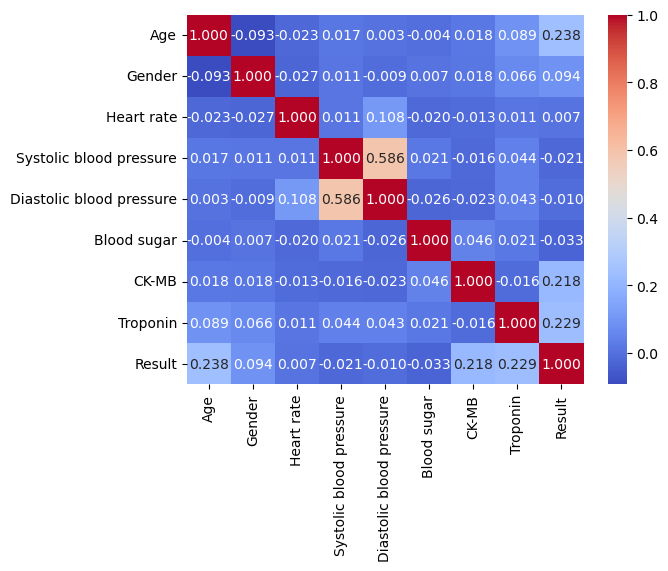

In [13]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.3f')
plt.show()

## Data Split and Scaling

### Assign X and y variables

In [14]:
X = df.drop(columns=['Result'])
X.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
0,64,1,66,160,83,160.0,1.80,0.012
1,21,1,94,98,46,296.0,6.75,1.060
2,55,1,64,160,77,270.0,1.99,0.003
3,64,1,70,120,55,270.0,13.87,0.122
4,55,1,64,112,65,300.0,1.08,0.003


In [15]:
y = df['Result']
y.head()

0    0
1    1
2    0
3    1
4    0
Name: Result, dtype: int64

### Test/Train Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

### Scale Data

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Prepare Data for Neural Network (Convert to PyTorch Tensors)

In [18]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print('Training samples:', X_train_tensor.shape[0])
print('Test samples:', X_test_tensor.shape[0])
print('Number of features:', X_train_tensor.shape[1])
print('\nTensor shapes:')
print('X_train_tensor:', X_train_tensor.shape)
print('X_test_tensor:', X_test_tensor.shape)
print('y_train_tensor:', y_train_tensor.shape)
print('y_test_tensor:', y_test_tensor.shape)
print('\nDevice:', device)

Training samples: 1055
Test samples: 264
Number of features: 8

Tensor shapes:
X_train_tensor: torch.Size([1055, 8])
X_test_tensor: torch.Size([264, 8])
y_train_tensor: torch.Size([1055, 1])
y_test_tensor: torch.Size([264, 1])

Device: cpu


## Neural Network (NN)

In [19]:
class HeartAttackNN(nn.Module):
    """
    BatchNorm + Dropout for regularization, ReLU activation
    Input -> hidden1 (64) -> hidden2 (32) -> hidden3 (16) -> output (1)
    """
    def __init__(self, input_size, hidden1=64, hidden2=32, hidden3=16, output_size=1, dropout=0.3):
        super(HeartAttackNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)
        
        #Dropout layer and dropout for regularization
        self.fc4 = nn.Linear(hidden3, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = torch.relu(out)
        out = self.dropout(out)
    
        out = torch.sigmoid(self.fc4(out))
        return out

### Hyperparameters for NN

In [20]:
# Hyperparams
default_hidden1 = 64
default_hidden2 = 32
default_hidden3 = 16
default_lr = 0.01
default_dropout = 0.3

print("HeartAttackNN Architecture (with BatchNorm + Dropout):")
print(f"  Input:   {X_train_tensor.shape[1]} features")
print(f"  Hidden1: {default_hidden1} neurons -> BatchNorm -> ReLU -> Dropout({default_dropout})")
print(f"  Hidden2: {default_hidden2} neurons -> BatchNorm -> ReLU -> Dropout({default_dropout})")
print(f"  Hidden3: {default_hidden3} neurons -> BatchNorm -> ReLU -> Dropout({default_dropout})")
print(f"  Output:  1 neuron -> Sigmoid")


HeartAttackNN Architecture (with BatchNorm + Dropout):
  Input:   8 features
  Hidden1: 64 neurons -> BatchNorm -> ReLU -> Dropout(0.3)
  Hidden2: 32 neurons -> BatchNorm -> ReLU -> Dropout(0.3)
  Hidden3: 16 neurons -> BatchNorm -> ReLU -> Dropout(0.3)
  Output:  1 neuron -> Sigmoid


#### Training Loop For NN

In [21]:
def train_nn(model, optimizer, criterion, X_train, y_train, num_epochs, patience=20, X_val=None, y_val=None):
    """
    Train the neural network with early stopping.
    If validation data is provided, early stopping uses validation loss.
    Otherwise, it uses training loss.
    """
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None   #Store best model weights
    has_validation = X_val is not None and y_val is not None
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if has_validation:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                check_loss = criterion(val_outputs, y_val).item()
        else:
            check_loss = loss.item()
        
        if check_loss < best_loss:
            best_loss = check_loss
            patience_counter = 0
            #Updates best model state
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    #restore best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model
        

#### Evaluation of NN

In [22]:
@torch.no_grad() #Disables gradient calculation for evaluation
def eval_nn(model, X_test, y_test):
    model.eval()
    y_prob = model(X_test).cpu().numpy().ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(y_test.cpu().numpy(), y_pred),
        "precision": precision_score(y_test.cpu().numpy(), y_pred),
        "recall": recall_score(y_test.cpu().numpy(), y_pred),
        "f1": f1_score(y_test.cpu().numpy(), y_pred),
        "auroc": roc_auc_score(y_test.cpu().numpy(), y_prob),
        "auprc": average_precision_score(y_test.cpu().numpy(), y_prob),
        "y_prob": y_prob,
        "y_pred": y_pred,
    }

#### K-Fold CV & Hyperparameter Tuning (NN)

In [23]:
nn_config_grid = [
    {"hidden1": 64,  "hidden2": 32, "hidden3": 16, "dropout": 0.2, "lr": 0.01,  "weight_decay": 1e-4, "epochs": 200},
    {"hidden1": 64,  "hidden2": 32, "hidden3": 16, "dropout": 0.3, "lr": 0.01,  "weight_decay": 1e-4, "epochs": 200},
    {"hidden1": 128, "hidden2": 64, "hidden3": 32, "dropout": 0.3, "lr": 0.01,  "weight_decay": 1e-4, "epochs": 200},
    {"hidden1": 128, "hidden2": 64, "hidden3": 32, "dropout": 0.4, "lr": 0.005, "weight_decay": 1e-4, "epochs": 200},
    {"hidden1": 64,  "hidden2": 32, "hidden3": 16, "dropout": 0.3, "lr": 0.005, "weight_decay": 1e-4, "epochs": 250},
    {"hidden1": 128, "hidden2": 64, "hidden3": 32, "dropout": 0.3, "lr": 0.005, "weight_decay": 1e-4, "epochs": 250},
    {"hidden1": 256, "hidden2": 128, "hidden3": 64, "dropout": 0.4, "lr": 0.001, "weight_decay": 1e-3, "epochs": 300},
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

cv_results_nn = []
best_cfg = None
best_mean_auroc = -np.inf

X_train_np = X_train.values
y_train_np = y_train.values      

for cfg in nn_config_grid:
    fold_aurocs = []

    print(f"\nEvaluating config: {cfg}")
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train_np, y_train_np), 1):
        scaler_fold = StandardScaler()
        X_tr_scaled = scaler_fold.fit_transform(X_train_np[train_idx])
        X_val_scaled = scaler_fold.transform(X_train_np[val_idx])
        
        X_tr = torch.tensor(X_tr_scaled, dtype=torch.float32).to(device)
        y_tr = torch.tensor(y_train_np[train_idx], dtype=torch.float32).unsqueeze(1).to(device)

        X_val = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val = torch.tensor(y_train_np[val_idx], dtype=torch.float32).unsqueeze(1).to(device)

        input_size = X_tr.shape[1]
        model_cv = HeartAttackNN(
            input_size=input_size,
            hidden1=cfg["hidden1"],
            hidden2=cfg["hidden2"],
            hidden3=cfg["hidden3"],
            dropout=cfg["dropout"],
            output_size=1
        ).to(device)

        criterion_cv = nn.BCELoss()
        optimizer_cv = optim.Adam(model_cv.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

        model_cv = train_nn(model_cv, optimizer_cv, criterion_cv, X_tr, y_tr, cfg["epochs"],
                           patience=30, X_val=X_val, y_val=y_val)

        metrics_val = eval_nn(model_cv, X_val, y_val)
        fold_aurocs.append(metrics_val["auroc"])

        print(f"  Fold {fold_idx}: AUROC = {metrics_val['auroc']:.4f}")

    mean_auroc = np.mean(fold_aurocs)
    cv_results_nn.append({"config": cfg, "mean_auroc": mean_auroc})

    print(f"Mean AUROC for config {cfg}: {mean_auroc:.4f}")

    if mean_auroc > best_mean_auroc:
        best_mean_auroc = mean_auroc
        best_cfg = cfg

print("\n" + "="*60)
print("Best NN config:", best_cfg)
print(f"Best mean CV AUROC: {best_mean_auroc:.4f}")
print("="*60)



Evaluating config: {'hidden1': 64, 'hidden2': 32, 'hidden3': 16, 'dropout': 0.2, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}
  Fold 1: AUROC = 0.9519
  Fold 2: AUROC = 0.9316
  Fold 3: AUROC = 0.9318
  Fold 4: AUROC = 0.9288
  Fold 5: AUROC = 0.9498
Mean AUROC for config {'hidden1': 64, 'hidden2': 32, 'hidden3': 16, 'dropout': 0.2, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}: 0.9388

Evaluating config: {'hidden1': 64, 'hidden2': 32, 'hidden3': 16, 'dropout': 0.3, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}
  Fold 1: AUROC = 0.9579
  Fold 2: AUROC = 0.9126
  Fold 3: AUROC = 0.9456
  Fold 4: AUROC = 0.9193
  Fold 5: AUROC = 0.9360
Mean AUROC for config {'hidden1': 64, 'hidden2': 32, 'hidden3': 16, 'dropout': 0.3, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}: 0.9343

Evaluating config: {'hidden1': 128, 'hidden2': 64, 'hidden3': 32, 'dropout': 0.3, 'lr': 0.01, 'weight_decay': 0.0001, 'epochs': 200}
  Fold 1: AUROC = 0.9397
  Fold 2: AUROC = 0.9276
  Fold 3: AURO

#### Retraining NN on full training set with best config of hyperparameters & evaluation of NN on test set

In [24]:
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train.values, y_train.values, test_size=0.15, random_state=seed, stratify=y_train
)

#scaling/transforming/fitting
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)
X_val_final_scaled = scaler_final.transform(X_val_final)
X_test_final_scaled = scaler_final.transform(X_test.values)

#tensor conversions
X_train_final_tensor = torch.tensor(X_train_final_scaled, dtype=torch.float32).to(device)
X_val_final_tensor = torch.tensor(X_val_final_scaled, dtype=torch.float32).to(device)
X_test_final_tensor = torch.tensor(X_test_final_scaled, dtype=torch.float32).to(device)
y_train_final_tensor = torch.tensor(y_train_final, dtype=torch.float32).unsqueeze(1).to(device)
y_val_final_tensor = torch.tensor(y_val_final, dtype=torch.float32).unsqueeze(1).to(device)
y_test_final_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

input_size = X_train_final_tensor.shape[1]

best_model_nn = HeartAttackNN(
    input_size=input_size,
    hidden1=best_cfg["hidden1"],
    hidden2=best_cfg["hidden2"],
    hidden3=best_cfg["hidden3"],
    dropout=best_cfg["dropout"],
    output_size=1
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(best_model_nn.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])


best_model_nn = train_nn(
    best_model_nn,
    optimizer,
    criterion,
    X_train_final_tensor,
    y_train_final_tensor,
    best_cfg["epochs"] + 100,
    patience=30,
    X_val=X_val_final_tensor,
    y_val=y_val_final_tensor
)

nn_results = eval_nn(best_model_nn, X_test_final_tensor, y_test_final_tensor)

print("\nFinal NN Test Results (using best config):")
for k, v in nn_results.items():
    if k in ["y_prob", "y_pred"]:
        continue
    print(f"{k}: {v}")

#Building a table we can call anywere
nn_rows = {
    "model": "Neural Network",
    "accuracy": nn_results["accuracy"],
    "precision": nn_results["precision"],
    "recall": nn_results["recall"],
    "f1": nn_results["f1"],
    "auroc": nn_results["auroc"],
    "auprc": nn_results["auprc"],
}
result_table_nn = []
result_table_nn.append(nn_rows)
pd.DataFrame(result_table_nn)


Final NN Test Results (using best config):
accuracy: 0.9090909090909091
precision: 0.96
recall: 0.8888888888888888
f1: 0.9230769230769231
auroc: 0.9615105301379812
auprc: 0.9797415862639636


,model,accuracy,precision,recall,f1,auroc,auprc
0,Neural Network,0.909091,0.96,0.888889,0.923077,0.961511,0.979742


## Random Forest Classifier

### Hyperparameter Options for Grid Search

In [25]:
hyparam_grid_rfc = {
    'n_estimators': [300, 600],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5]
}

### Initialize Random Forest Classifier

In [26]:
model_rfc = RandomForestClassifier(random_state=seed)

### Run a Grid Search to Find Best Hyperparameters

In [27]:
grid_rfc = GridSearchCV(
    estimator=model_rfc,
    scoring='accuracy',
    cv=3,
    param_grid=hyparam_grid_rfc,
    n_jobs=-1  # my toaster breaks if I use -1, so I optimized for it on my toaster. Adjust as needed.
)

In [28]:
grid_rfc.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [29]:
print('Best accuracy: ', grid_rfc.best_score_)
print('Best Set of Hyperparameters: ', grid_rfc.best_params_)

Best accuracy:  0.9867397263230596
Best Set of Hyperparameters:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Assign the Best Hyperparameters to the Random Forest Classifier

In [30]:
model_rfc = grid_rfc.best_estimator_

### Examine Performance of Random Forest Classifier Model

In [31]:
y_val_pred_rfc = model_rfc.predict(X_test)
y_val_proba_rfc = model_rfc.predict_proba(X_test)[:,1]

acc_rfc = accuracy_score(y_test, y_val_pred_rfc)
auc_rfc = roc_auc_score(y_test, y_val_proba_rfc)
auprc_rfc = average_precision_score(y_test, y_val_proba_rfc)
precision_rfc = precision_score(y_test, y_val_pred_rfc)
recall_rfc = recall_score(y_test, y_val_pred_rfc)
f1_rfc = f1_score(y_test, y_val_pred_rfc)

print('Random Forest Classifier Results:')
print(f'  Accuracy:  {acc_rfc:.4f}')
print(f'  Precision: {precision_rfc:.4f}')
print(f'  Recall:    {recall_rfc:.4f}')
print(f'  F1:        {f1_rfc:.4f}')
print(f'  AUROC:     {auc_rfc:.4f}')
print(f'  AUPRC:     {auprc_rfc:.4f}')

# Save results to dict for combined DataFrame
rf_rows = {
    "model": "Random Forest",
    "accuracy": acc_rfc,
    "precision": precision_rfc,
    "recall": recall_rfc,
    "f1": f1_rfc,
    "auroc": auc_rfc,
    "auprc": auprc_rfc,
}

Random Forest Classifier Results:
  Accuracy:  0.9811
  Precision: 0.9876
  Recall:    0.9815
  F1:        0.9845
  AUROC:     0.9869
  AUPRC:     0.9934


### Bootstrapping for Random Forest (Variance Estimation & 95% CI)


In [32]:
B = 200
best_params_rf = grid_rfc.best_params_

rf_boot_auroc = []
rf_boot_auprc = []
rf_boot_accuracy = []
rf_boot_f1 = []

print(f"Running {B} bootstrap replicates for Random Forest...")
print(f"Best RF params: {best_params_rf}")
print("-" * 50)

for b in range(B):
    X_train_boot, y_train_boot = resample(
        X_train, y_train, 
        replace=True, 
        n_samples=len(X_train), 
        random_state=seed + b
    )
    rf_b = RandomForestClassifier(**best_params_rf, random_state=seed)
    rf_b.fit(X_train_boot, y_train_boot)
    
    y_pred_b = rf_b.predict(X_test)
    y_proba_b = rf_b.predict_proba(X_test)[:, 1]
    rf_boot_auroc.append(roc_auc_score(y_test, y_proba_b))
    rf_boot_auprc.append(average_precision_score(y_test, y_proba_b))
    rf_boot_accuracy.append(accuracy_score(y_test, y_pred_b))
    rf_boot_f1.append(f1_score(y_test, y_pred_b))
    
    if (b + 1) % 25 == 0:
        print(f"  Completed {b + 1}/{B} replicates")

rf_boot_auroc = np.array(rf_boot_auroc)
rf_boot_auprc = np.array(rf_boot_auprc)
rf_boot_accuracy = np.array(rf_boot_accuracy)
rf_boot_f1 = np.array(rf_boot_f1)

#statistics and 95% CI (percentile method)
print("\n" + "=" * 60)
print("RANDOM FOREST BOOTSTRAP RESULTS (B = {})".format(B))
print("=" * 60)

rf_bootstrap_results = {}
for metric_name, metric_values in [
    ("AUROC", rf_boot_auroc),
    ("AUPRC", rf_boot_auprc),
    ("Accuracy", rf_boot_accuracy),
    ("F1", rf_boot_f1)
]:
    mean_val = np.mean(metric_values)
    std_val = np.std(metric_values)
    ci_lower = np.percentile(metric_values, 2.5)
    ci_upper = np.percentile(metric_values, 97.5)
    
    rf_bootstrap_results[metric_name] = {
        'mean': mean_val,
        'std': std_val,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    
    print(f"{metric_name:12s}: Mean = {mean_val:.4f}, Std = {std_val:.4f}, 95% CI = [{ci_lower:.4f}, {ci_upper:.4f}]")

print("=" * 60)


Running 200 bootstrap replicates for Random Forest...
Best RF params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
--------------------------------------------------
  Completed 25/200 replicates
  Completed 50/200 replicates
  Completed 75/200 replicates
  Completed 100/200 replicates
  Completed 125/200 replicates
  Completed 150/200 replicates
  Completed 175/200 replicates
  Completed 200/200 replicates

RANDOM FOREST BOOTSTRAP RESULTS (B = 200)
AUROC       : Mean = 0.9860, Std = 0.0022, 95% CI = [0.9821, 0.9903]
AUPRC       : Mean = 0.9920, Std = 0.0016, 95% CI = [0.9882, 0.9946]
Accuracy    : Mean = 0.9810, Std = 0.0007, 95% CI = [0.9811, 0.9811]
F1          : Mean = 0.9845, Std = 0.0006, 95% CI = [0.9845, 0.9845]


## XGBoost

### Hyperparameter Grid

In [33]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

### Initalize Model and Find Best Hyperparameters

In [34]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

grid = GridSearchCV(
    estimator=xgb,
    scoring='accuracy',
    cv=3,
    param_grid=param_grid,
    n_jobs=-1  
)

grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

xgb = grid.best_estimator_

y_val_pred_xgb = xgb.predict(X_test)
y_val_proba_xgb = xgb.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_val_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_val_proba_xgb)
auprc_xgb = average_precision_score(y_test, y_val_proba_xgb)
precision_xgb = precision_score(y_test, y_val_pred_xgb)
recall_xgb = recall_score(y_test, y_val_pred_xgb)
f1_xgb = f1_score(y_test, y_val_pred_xgb)

print('XGBoost Results:')
print(f'  Accuracy:  {acc_xgb:.4f}')
print(f'  Precision: {precision_xgb:.4f}')
print(f'  Recall:    {recall_xgb:.4f}')
print(f'  F1:        {f1_xgb:.4f}')
print(f'  AUROC:     {auc_xgb:.4f}')
print(f'  AUPRC:     {auprc_xgb:.4f}')

xgb_rows = {
    "model": "XGBoost",
    "accuracy": acc_xgb,
    "precision": precision_xgb,
    "recall": recall_xgb,
    "f1": f1_xgb,
    "auroc": auc_xgb,
    "auprc": auprc_xgb,
}


0.9876866960200293
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGBoost Results:
  Accuracy:  0.9811
  Precision: 0.9876
  Recall:    0.9815
  F1:        0.9845
  AUROC:     0.9862
  AUPRC:     0.9862


### Bootstrapping for XGBoost (Variance Estimation & 95% CI)


In [35]:
B = 200  # Number of bootstrap replicates
best_params_xgb = grid.best_params_
xgb_boot_auroc = []
xgb_boot_auprc = []
xgb_boot_accuracy = []
xgb_boot_f1 = []

print(f"Running {B} bootstrap replicates for XGBoost...")
print(f"Best XGB params: {best_params_xgb}")
print("-" * 50)

for b in range(B):
    #sample bootstrap training set (with replacement)
    X_train_boot, y_train_boot = resample(
        X_train, y_train, 
        replace=True, 
        n_samples=len(X_train), 
        random_state=seed + b
    )
    
    xgb_b = XGBClassifier(
        **best_params_xgb, 
        random_state=seed, 
        eval_metric='logloss'
    )
    xgb_b.fit(X_train_boot, y_train_boot, verbose=False)
    
    y_pred_b = xgb_b.predict(X_test)
    y_proba_b = xgb_b.predict_proba(X_test)[:, 1]

    xgb_boot_auroc.append(roc_auc_score(y_test, y_proba_b))
    xgb_boot_auprc.append(average_precision_score(y_test, y_proba_b))
    xgb_boot_accuracy.append(accuracy_score(y_test, y_pred_b))
    xgb_boot_f1.append(f1_score(y_test, y_pred_b))
    
    if (b + 1) % 25 == 0:
        print(f"  Completed {b + 1}/{B} replicates")

xgb_boot_auroc = np.array(xgb_boot_auroc)
xgb_boot_auprc = np.array(xgb_boot_auprc)
xgb_boot_accuracy = np.array(xgb_boot_accuracy)
xgb_boot_f1 = np.array(xgb_boot_f1)

#statistics and 95% CI (percentile method)
print("\n" + "=" * 60)
print("XGBOOST BOOTSTRAP RESULTS (B = {})".format(B))
print("=" * 60)

xgb_bootstrap_results = {}
for metric_name, metric_values in [
    ("AUROC", xgb_boot_auroc),
    ("AUPRC", xgb_boot_auprc),
    ("Accuracy", xgb_boot_accuracy),
    ("F1", xgb_boot_f1)
]:
    mean_val = np.mean(metric_values)
    std_val = np.std(metric_values)
    ci_lower = np.percentile(metric_values, 2.5)
    ci_upper = np.percentile(metric_values, 97.5)
    
    xgb_bootstrap_results[metric_name] = {
        'mean': mean_val,
        'std': std_val,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    
    print(f"{metric_name:12s}: Mean = {mean_val:.4f}, Std = {std_val:.4f}, 95% CI = [{ci_lower:.4f}, {ci_upper:.4f}]")

print("=" * 60)


Running 200 bootstrap replicates for XGBoost...
Best XGB params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
--------------------------------------------------


  Completed 25/200 replicates
  Completed 50/200 replicates
  Completed 75/200 replicates
  Completed 100/200 replicates
  Completed 125/200 replicates
  Completed 150/200 replicates
  Completed 175/200 replicates
  Completed 200/200 replicates

XGBOOST BOOTSTRAP RESULTS (B = 200)
AUROC       : Mean = 0.9876, Std = 0.0015, 95% CI = [0.9860, 0.9894]
AUPRC       : Mean = 0.9872, Std = 0.0011, 95% CI = [0.9860, 0.9884]
Accuracy    : Mean = 0.9806, Std = 0.0017, 95% CI = [0.9772, 0.9811]
F1          : Mean = 0.9842, Std = 0.0014, 95% CI = [0.9813, 0.9845]


### Bootstrap Results Summary (RF vs XGBoost)


In [36]:
summary_data = []
for metric in ['AUROC', 'AUPRC', 'Accuracy', 'F1']:
    rf_res = rf_bootstrap_results[metric]
    xgb_res = xgb_bootstrap_results[metric]
    
    summary_data.append({
        'Metric': metric,
        'RF Mean': f"{rf_res['mean']:.4f}",
        'RF 95% CI': f"[{rf_res['ci_lower']:.4f}, {rf_res['ci_upper']:.4f}]",
        'RF Std': f"{rf_res['std']:.4f}",
        'XGB Mean': f"{xgb_res['mean']:.4f}",
        'XGB 95% CI': f"[{xgb_res['ci_lower']:.4f}, {xgb_res['ci_upper']:.4f}]",
        'XGB Std': f"{xgb_res['std']:.4f}",
    })

bootstrap_summary_df = pd.DataFrame(summary_data)
print("=" * 80)
print("Bootstrap Summary (B = 200 replicates)")
print("=" * 80)
print(bootstrap_summary_df.to_string(index=False))
print("=" * 80)

# Display as formatted table
bootstrap_summary_df


Bootstrap Summary (B = 200 replicates)
  Metric RF Mean        RF 95% CI RF Std XGB Mean       XGB 95% CI XGB Std
   AUROC  0.9860 [0.9821, 0.9903] 0.0022   0.9876 [0.9860, 0.9894]  0.0015
   AUPRC  0.9920 [0.9882, 0.9946] 0.0016   0.9872 [0.9860, 0.9884]  0.0011
Accuracy  0.9810 [0.9811, 0.9811] 0.0007   0.9806 [0.9772, 0.9811]  0.0017
      F1  0.9845 [0.9845, 0.9845] 0.0006   0.9842 [0.9813, 0.9845]  0.0014


,Metric,RF Mean,RF 95% CI,RF Std,XGB Mean,XGB 95% CI,XGB Std
0,AUROC,0.9860,"[0.9821, 0.9903]",0.0022,0.9876,"[0.9860, 0.9894]",0.0015
1,AUPRC,0.9920,"[0.9882, 0.9946]",0.0016,0.9872,"[0.9860, 0.9884]",0.0011
2,Accuracy,0.9810,"[0.9811, 0.9811]",0.0007,0.9806,"[0.9772, 0.9811]",0.0017
3,F1,0.9845,"[0.9845, 0.9845]",0.0006,0.9842,"[0.9813, 0.9845]",0.0014


## TabPFN

### Initialize TabPFN Model

In [37]:
model_tabPFN = TabPFNClassifier(
    random_state=seed, 
    device="cpu", 
    n_estimators=8,
    model_path="tabpfn-v2-classifier.ckpt",     # ungated model, shouldn't require HuggingFace account authentication
    ignore_pretraining_limits=True              # cpu safety limit is capped at 1000 rows, but ours is 1300, so ignore limit
    )

### Fit and Examine Performance of TabPFN

In [38]:
model_tabPFN.fit(X_train, y_train)

,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,balance_probabilities,False
,average_before_softmax,False
,model_path,'tabpfn-v2-classifier.ckpt'
,device,'cpu'
,ignore_pretraining_limits,True
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'


In [39]:
y_val_pred_tabPFN = model_tabPFN.predict(X_test)
y_val_proba_tabPFN = model_tabPFN.predict_proba(X_test)[:,1]

acc_tabPFN = accuracy_score(y_test, y_val_pred_tabPFN)
auc_tabPFN = roc_auc_score(y_test, y_val_proba_tabPFN)
auprc_tabPFN = average_precision_score(y_test, y_val_proba_tabPFN)
precision_tabPFN = precision_score(y_test, y_val_pred_tabPFN)
recall_tabPFN = recall_score(y_test, y_val_pred_tabPFN)
f1_tabPFN = f1_score(y_test, y_val_pred_tabPFN)

print('TabPFN Results:')
print(f'  Accuracy:  {acc_tabPFN:.4f}')
print(f'  Precision: {precision_tabPFN:.4f}')
print(f'  Recall:    {recall_tabPFN:.4f}')
print(f'  F1:        {f1_tabPFN:.4f}')
print(f'  AUROC:     {auc_tabPFN:.4f}')
print(f'  AUPRC:     {auprc_tabPFN:.4f}')

tabpfn_rows = {
    "model": "TabPFN",
    "accuracy": acc_tabPFN,
    "precision": precision_tabPFN,
    "recall": recall_tabPFN,
    "f1": f1_tabPFN,
    "auroc": auc_tabPFN,
    "auprc": auprc_tabPFN,
}

TabPFN Results:
  Accuracy:  0.9811
  Precision: 0.9876
  Recall:    0.9815
  F1:        0.9845
  AUROC:     0.9896
  AUPRC:     0.9917


## Ensemble Model (NN + Random Forest Classifier + XGBoost + TabPFN)

### Sklearn NN Wrapper for Ensemble

In [40]:
"""
Sklearn-compatible Neural Network classifier for heart attack prediction.
It uses the HeartAttackNN architecture as defined in the NN section.
This is added to allow the Nn to be used with sklearn's ensemble methods
"""
class HeartAttackNeuralNetwork(BaseEstimator, ClassifierMixin):

    _estimator_type = "classifier" #DONT REMOVE, NEEDED TO TELL SKLEARN THAT THIS IS A CLASSIFIER
    
    def __init__(self, input_size=8, hidden1=64, hidden2=32, hidden3=16, dropout=0.3, lr=0.01, weight_decay=1e-4, epochs=200, patience=30, device="cpu"):
        self.input_size = input_size
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.hidden3 = hidden3
        self.dropout = dropout
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.patience = patience
        self.device = device
        self._model = None
        self._best_model_state = None

    def _build(self):
        self._model = HeartAttackNN(
            input_size=self.input_size,
            hidden1=self.hidden1,
            hidden2=self.hidden2,
            hidden3=self.hidden3,
            dropout=self.dropout,
            output_size=1
        ).to(self.device)

    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values
            
        self._scaler = StandardScaler()
        X_scaled = self._scaler.fit_transform(X)
        
        X_t = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
        y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(self.device)
        
        self._build()
        opt = optim.Adam(self._model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.BCELoss()
        
        best_loss = float('inf')
        patience_counter = 0
        self._best_model_state = None
        
        self._model.train()
        for _ in range(self.epochs):
            opt.zero_grad()
            out = self._model(X_t)
            loss = crit(out, y_t)
            loss.backward()
            opt.step()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                patience_counter = 0
                self._best_model_state = {k: v.clone() for k, v in self._model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break
        
        if self._best_model_state is not None:
            self._model.load_state_dict(self._best_model_state)
        
        return self

    def predict_proba(self, X):
        if hasattr(X, 'values'):
            X = X.values
        
        X_scaled = self._scaler.transform(X)
        
        self._model.eval()
        X_t = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            p1 = self._model(X_t).cpu().numpy().ravel()
        p0 = 1.0 - p1
        return np.vstack([p0, p1]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)
    
    @property
    def classes_(self):
        return np.array([0, 1])
    
    def __sklearn_tags__(self):
        return Tags(
            estimator_type="classifier",
            input_tags=InputTags(),
            target_tags=TargetTags(required=True),
            classifier_tags=ClassifierTags()
        )

In [41]:
#NN classifier with best hyperparameters from CV
nn_classifier = HeartAttackNeuralNetwork(
    input_size=X_train.shape[1],
    hidden1=best_cfg["hidden1"],
    hidden2=best_cfg["hidden2"],
    hidden3=best_cfg["hidden3"],
    dropout=best_cfg["dropout"],
    lr=best_cfg["lr"],
    weight_decay=best_cfg["weight_decay"],
    epochs=best_cfg["epochs"],
    patience=30,
    device=str(device)
)
print(f"HeartAttackNeuralNetwork initialized with best config: {best_cfg}")


HeartAttackNeuralNetwork initialized with best config: {'hidden1': 64, 'hidden2': 32, 'hidden3': 16, 'dropout': 0.3, 'lr': 0.005, 'weight_decay': 0.0001, 'epochs': 250}


### Initialize Ensemble Voter with the 4 Models

In [42]:
ens_voter = VotingClassifier(
    estimators=[ ("nn", nn_classifier), ("rf", model_rfc), ("xgb", xgb), ("tabpfn", model_tabPFN) ],
    voting='soft',
    weights=[1, 1, 1, 1]
)

### Fit Ensemble and Evaluate Performance

In [43]:
ens_voter.fit(X_train, y_train)

,estimators,"[('nn', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,"[1, 1, ...]"
,n_jobs,None
,flatten_transform,True
,verbose,False
,input_size,8
,hidden1,64
,hidden2,32
,hidden3,16
,dropout,0.3


In [44]:
y_val_pred_ens = ens_voter.predict(X_test)
y_val_proba_ens = ens_voter.predict_proba(X_test)[:, 1]

acc_ens = accuracy_score(y_test, y_val_pred_ens)
auc_ens = roc_auc_score(y_test, y_val_proba_ens)
auprc_ens = average_precision_score(y_test, y_val_proba_ens)
precision_ens = precision_score(y_test, y_val_pred_ens)
recall_ens = recall_score(y_test, y_val_pred_ens)
f1_ens = f1_score(y_test, y_val_pred_ens)

print('Ensemble Results:')
print(f'  Accuracy:  {acc_ens:.4f}')
print(f'  Precision: {precision_ens:.4f}')
print(f'  Recall:    {recall_ens:.4f}')
print(f'  F1:        {f1_ens:.4f}')
print(f'  AUROC:     {auc_ens:.4f}')
print(f'  AUPRC:     {auprc_ens:.4f}')

ens_rows = {
    "model": "Ensemble",
    "accuracy": acc_ens,
    "precision": precision_ens,
    "recall": recall_ens,
    "f1": f1_ens,
    "auroc": auc_ens,
    "auprc": auprc_ens,
}

Ensemble Results:
  Accuracy:  0.9811
  Precision: 0.9876
  Recall:    0.9815
  F1:        0.9845
  AUROC:     0.9901
  AUPRC:     0.9938


## Combined Results Summary & Comparison


### Comparing Accuracy, Precision, Recall, F1-Score, AUROC, and AUPRC

In [45]:
all_results = [nn_rows, rf_rows, xgb_rows, tabpfn_rows, ens_rows]
results_df = pd.DataFrame(all_results)
numeric_cols = ['accuracy', 'precision', 'recall', 'f1', 'auroc', 'auprc']
results_df[numeric_cols] = results_df[numeric_cols].round(4)
print("=" * 80)
print("ALL MODELS - PERFORMANCE COMPARISON")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)
results_df


ALL MODELS - PERFORMANCE COMPARISON
         model  accuracy  precision  recall     f1  auroc  auprc
Neural Network    0.9091     0.9600  0.8889 0.9231 0.9615 0.9797
 Random Forest    0.9811     0.9876  0.9815 0.9845 0.9869 0.9934
       XGBoost    0.9811     0.9876  0.9815 0.9845 0.9862 0.9862
        TabPFN    0.9811     0.9876  0.9815 0.9845 0.9896 0.9917
      Ensemble    0.9811     0.9876  0.9815 0.9845 0.9901 0.9938


,model,accuracy,precision,recall,f1,auroc,auprc
0,Neural Network,0.9091,0.9600,0.8889,0.9231,0.9615,0.9797
1,Random Forest,0.9811,0.9876,0.9815,0.9845,0.9869,0.9934
2,XGBoost,0.9811,0.9876,0.9815,0.9845,0.9862,0.9862
3,TabPFN,0.9811,0.9876,0.9815,0.9845,0.9896,0.9917
4,Ensemble,0.9811,0.9876,0.9815,0.9845,0.9901,0.9938


### Comparing Confusion Matrixes of Each Model

In [81]:
def cm_plot(ax, model_name, y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred, normalize=None, labels=[0,1])
    
    sns.heatmap(cm, cmap='Blues', square=True, annot=True, fmt='d', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

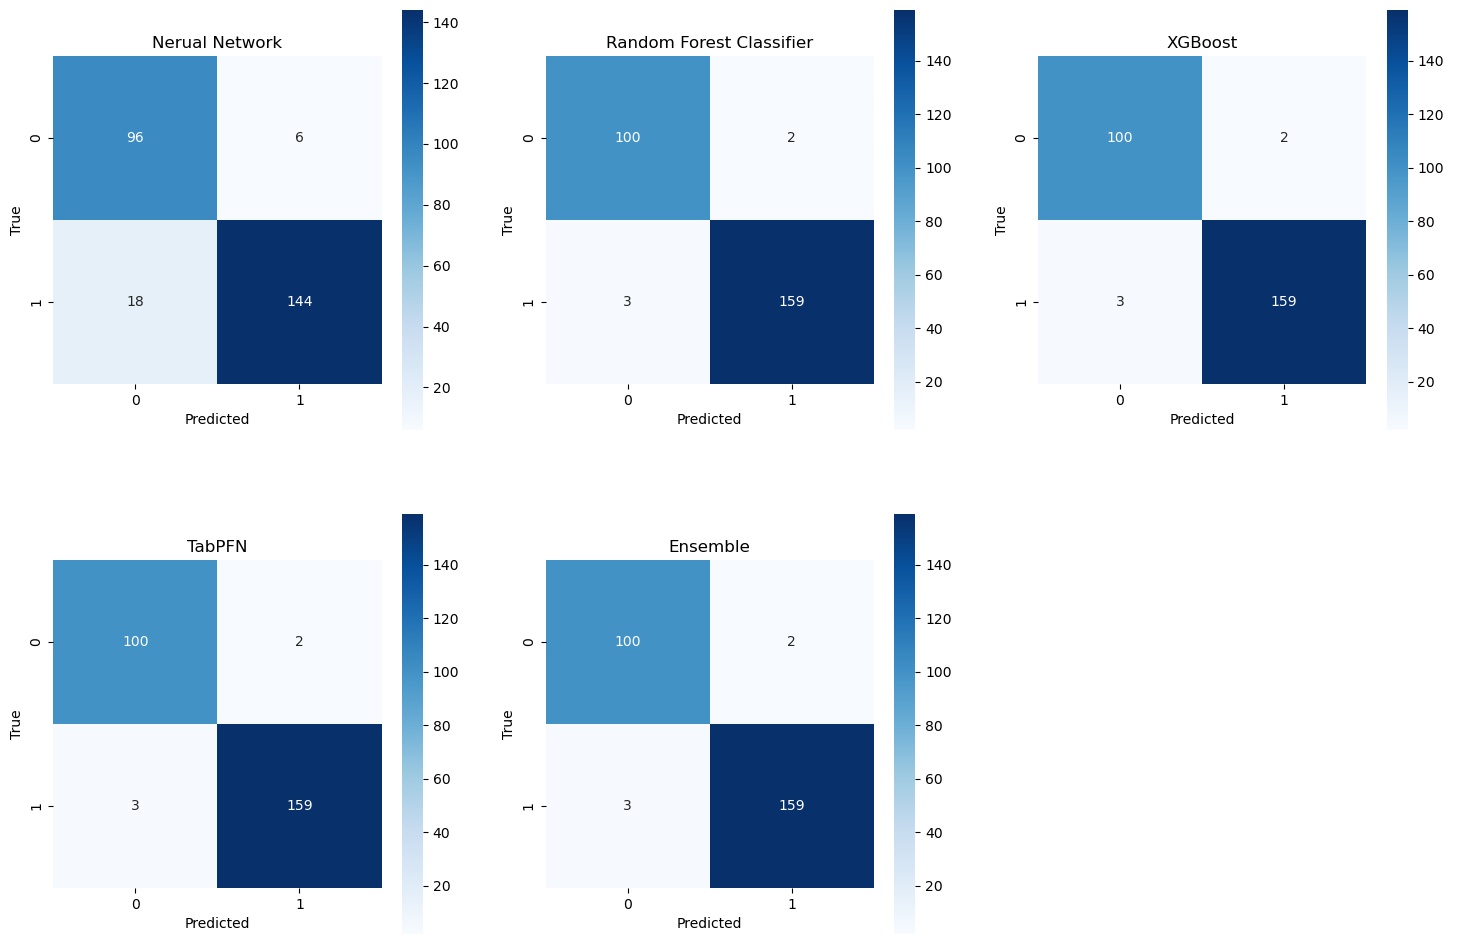

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

cm_plot(axes[0, 0], "Nerual Network", y_test, nn_results['y_pred'])
cm_plot(axes[0, 1], "Random Forest Classifier", y_test, y_val_pred_rfc)
cm_plot(axes[0, 2], "XGBoost", y_test, y_val_pred_xgb)
cm_plot(axes[1, 0], "TabPFN", y_test, y_val_pred_tabPFN)
cm_plot(axes[1, 1], "Ensemble", y_test, y_val_pred_ens)

axes[1, 2].axis("off")

### Comparing ROC & AUROC Visually for Each Model

In [103]:
def roc_plot(ax, title, y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba)

    ax.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc_val:.5f}", color='red')
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Chance")
    ax.set_title(title)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

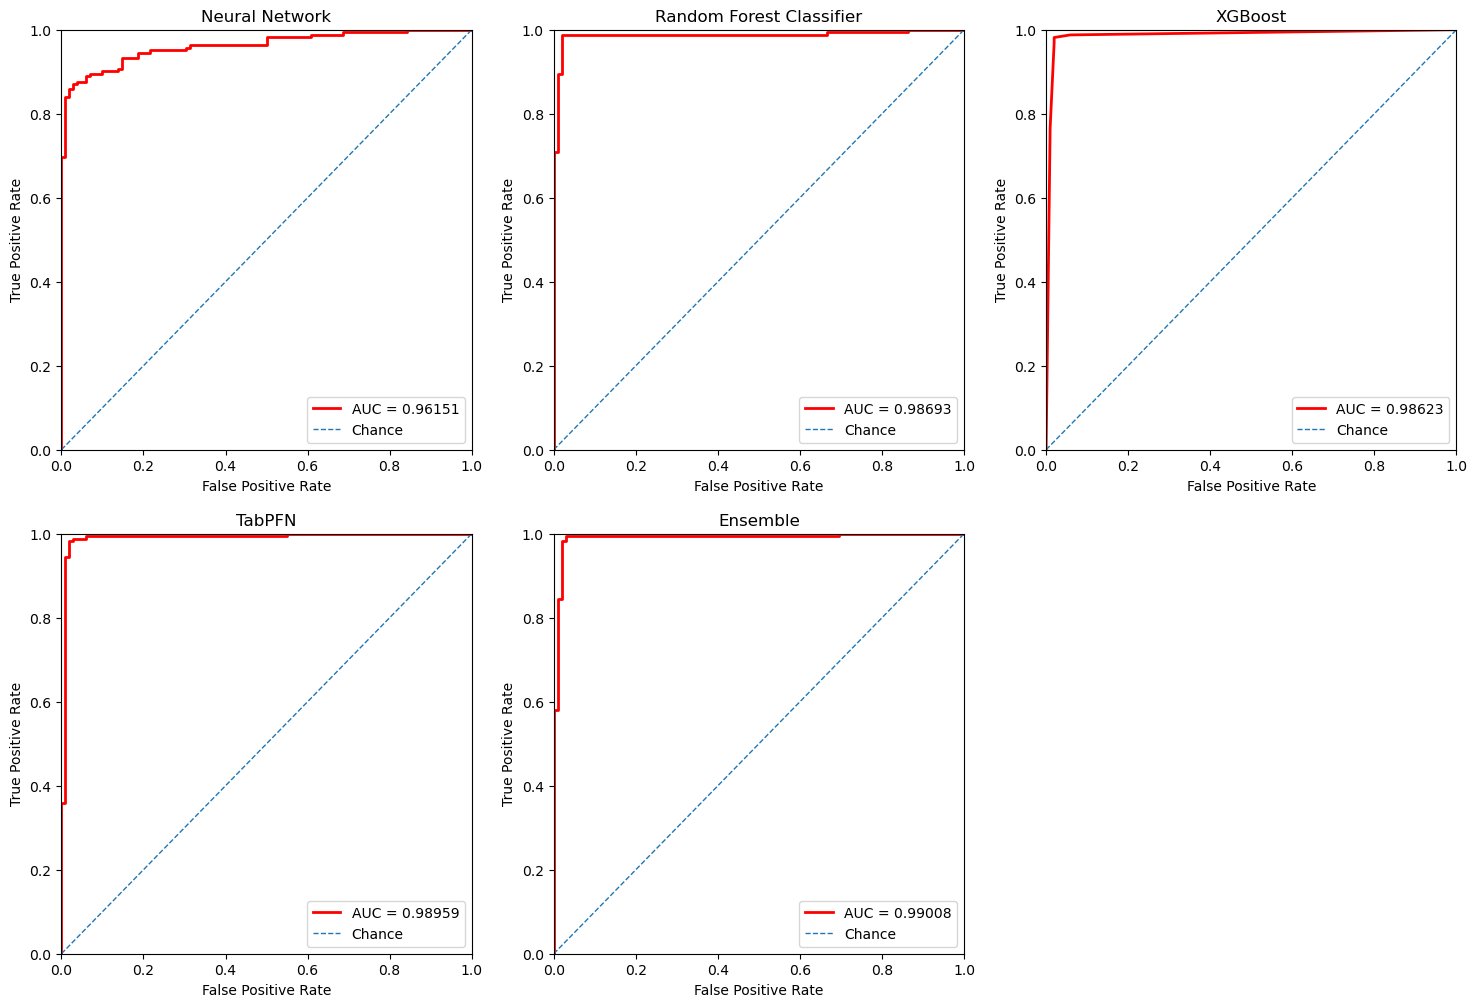

In [104]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

roc_plot(axes[0, 0], "Neural Network", y_test, nn_results['y_prob'])
roc_plot(axes[0, 1], "Random Forest Classifier", y_test, y_val_proba_rfc)
roc_plot(axes[0, 2], "XGBoost", y_test, y_val_proba_xgb)
roc_plot(axes[1, 0], "TabPFN", y_test, y_val_proba_tabPFN)
roc_plot(axes[1, 1], "Ensemble", y_test, y_val_proba_ens)

axes[1, 2].axis("off")